In [1]:
# import all
from torch import nn
import torch
import gymnasium as gym
from collections import deque 
import itertools 
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical 
import matplotlib.pyplot as plt 

In [2]:
# Values to be used 

gamma                   = 0.99   # discount rate 
batch_size              = 32
buffer_size             = 50000
replay_size             = 1000
epsilon_start           = 1.0
epsilon_end             = 0.02
epsilon_decay           = 10000
target_update_frequency = 1000
learning_rate           = 5e-4
icm_learning_rate       = 1e-4

# Whether to use ICM or not 
# is_icm = True 

In [3]:
# create environment 

env = gym.make("CartPole-v1")
#env = gym.make("MountainCar-v0")


input_shape = int(np.prod(env.observation_space.shape))
output_shape = env.action_space.n
print(input_shape)
print(output_shape)

4
2


In [10]:
replay_buffer = deque(maxlen = buffer_size)
reward_buffer = deque([0.0], maxlen = 100)

curr_reward   = 0.0

In [6]:
# Neural network class 
# nn.Sequential creates the required hidden layers in the order provided 

class Network(nn.Module):
    
    def __init__(self,env):
        super().__init__()
        
        input_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential( nn.Linear(input_features , 64) 
                                 , nn.Tanh() 
                                 , nn.Linear( 64 , env.action_space.n))
        
    def forward(self,x):
        return self.net(x)
    
    def act(self,curr_state):
        
        #convert the current state to a pytorch tensor 
        curr_state_t = torch.as_tensor(curr_state , dtype = torch.float32)
        q_values     = self(curr_state_t.unsqueeze(0))
        
        max_q        = torch.argmax(q_values , dim=1)[0]
        action       = max_q.detach().item()
        
        return action 
    
                   

## DQN + ICM Implementation ##

In [11]:
class ICM(nn.Module):
    def __init__(self , input_dim , output_dim ,alpha=1 , beta=0.2  ):
        
        super(ICM,self).__init__()
        self.alpha = alpha 
        self.beta = beta 
        
        #input_dim = input_dim[0]
        self.inverse = nn.Linear(input_dim * 2 , 256)
        self.pi_logits = nn.Linear(256 , output_dim)
        
        self.dense1 = nn.Linear(input_dim + 1 , 256)
        self.new_state = nn.Linear(256, input_dim)
        
    def forward(self , state , new_state , action ):
        
        inverse = F.elu(self.inverse(torch.cat([state, new_state], dim=1)))
        pi_logits = self.pi_logits(inverse)

        # from [T] to [T,1]
        action = action.reshape((action.size()[0], 1))
        forward_input = torch.cat([state, action], dim=1)
        dense = F.elu(self.dense1(forward_input))
        state_ = self.new_state(dense)

        return pi_logits, state_

    def calc_loss(self, state, new_state, action):
        state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        new_state = torch.tensor(new_state, dtype=torch.float)

        pi_logits, state_ = self.forward(state, new_state, action)

        inverse_loss = nn.MSELoss()
        L_I = (1-self.beta)*inverse_loss(pi_logits, action)

        forward_loss = nn.MSELoss()
        L_F = self.beta*forward_loss(state_, new_state)

        intrinsic_reward = self.alpha*((state_ - new_state).pow(2)).mean(dim=1)
        return intrinsic_reward, L_I, L_F

In [12]:
# create networks 

online_network = Network(env)
target_network = Network(env)

icm_network    = ICM(input_shape , output_shape) ######

# copy one network to another 
# load_state_dict is used to copy one model parameters to another 
target_network.load_state_dict(online_network.state_dict())

optimizer = torch.optim.Adam(online_network.parameters() , lr=learning_rate)
icm_optimizer = torch.optim.Adam(icm_network.parameters() , lr = icm_learning_rate  ) ######

In [13]:
# Initialize the replay buffer 

curr_state , info = env.reset()

for _ in range(replay_size):
    
    # take a random action
    action = env.action_space.sample()
    new_state , reward , terminated , truncated, info = env.step(action)
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated ,truncated, new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    
    if terminated or truncated :
        curr_state , info = env.reset()

In [14]:
# Training the agent 

curr_state , info = env.reset()
episode_n = 0
episodic_rewards = []

for i in itertools.count():
    
    # Epsilon Greedy Strategy to explore 
    epsilon = np.interp( i , [0,epsilon_decay] ,[ epsilon_start,epsilon_end ] )
    random_value = random.random()
    
    if random_value <= epsilon:
        action = env.action_space.sample()
    else :
        action = online_network.act(curr_state)
    
    new_state , reward , terminated , truncated , info = env.step(action)
    
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated , truncated , new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    curr_reward += reward 
    
    if terminated or truncated :
        curr_state , info = env.reset()
        
        reward_buffer.append(curr_reward)
        curr_reward = 0.0
        
        episode_n +=1 
        episodic_rewards.append(np.mean(reward_buffer))
        
        if episode_n % 50 == 0 :
            print(episode_n)
            print(np.mean(reward_buffer))
        
    
    # For rendering the code , beware of decommenting as your kernel can crash
#     if len(reward_buffer) >=100:
#         if np.mean(reward_buffer)>=200:
#             while True :
#                 action = online_network.act(curr_state)
                
#                 curr_state , reward , terminated , truncated , info = env.step(action)
#                 env.render()
                
#                 if terminated or truncated:
#                     env.reset
    
    
    # Extract parameters for Gradient Descent 
    experiences  = random.sample( replay_buffer , batch_size )
    
    
    curr_states  = np.asarray([e[0] for e in experiences])
    actions      = np.asarray([e[1] for e in experiences])
    rewards      = np.asarray([e[2] for e in experiences])
    terminated_s = np.asarray([e[3] for e in experiences])
    truncated_s  = np.asarray([e[4] for e in experiences])
    new_states   = np.asarray([e[5] for e in experiences])
    
    curr_states_t   = torch.as_tensor(curr_states, dtype=torch.float32)
    actions_t       = torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
    rewards_t       = torch.as_tensor(rewards,dtype=torch.float32).unsqueeze(-1)
    terminated_s_t  = torch.as_tensor(terminated_s,dtype=torch.float32).unsqueeze(-1)
    truncated_s_t   = torch.as_tensor(truncated_s,dtype=torch.float32).unsqueeze(-1)
    new_states_t    = torch.as_tensor(new_states,dtype=torch.float32)
    
    intrinsic_reward, L_I, L_F = icm_network.calc_loss(curr_states_t, new_states_t, actions_t)
    rewards_t += intrinsic_reward.detach().numpy()
    
    # Compute Targets 
    target_q_values      = target_network(new_states_t)
    max_target_q_values  = target_q_values.max(dim=1, keepdim=True)[0]
    
    
    temp = torch.logical_or(terminated_s_t,truncated_s_t)
    targets = rewards_t + gamma * (torch.logical_not(temp)) * max_target_q_values
    
    # Compute TD errors
    q_values        = online_network(curr_states_t)
    action_q_values = torch.gather(input=q_values , dim=1 , index=actions_t)
    
    error = nn.functional.smooth_l1_loss(action_q_values , targets)  # Huber loss
    
    # Gradient Descent 
    icm_optimizer.zero_grad()
    (L_I + L_F).backward()
    icm_optimizer.step()
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    # Update Target network 
    if i%target_update_frequency==0:
        target_network.load_state_dict(online_network.state_dict())
        
#     # Logging 
#     if i%1000==0:
#         print()
#         print("Steps" , i)
#         print("Average Reward" , np.mean(reward_buffer))
        
    if episode_n == 1000:
        break
    

/var/folders/sc/63b24d_x7_q7jtckgsd8mx000000gn/T/ipykernel_33815/108214652.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float)
/var/folders/sc/63b24d_x7_q7jtckgsd8mx000000gn/T/ipykernel_33815/108214652.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)
/var/folders/sc/63b24d_x7_q7jtckgsd8mx000000gn/T/ipykernel_33815/108214652.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_state = torch.tensor(new_state, dtype=torch.float)
/Users/ki

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


Text(0.5, 1.0, 'DQN + ICM')

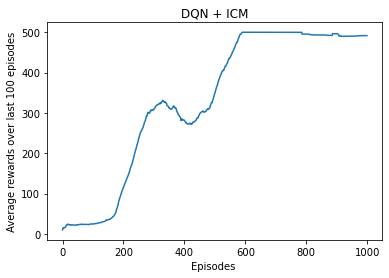

In [15]:
# We have episodic rewards with us 
#print(episodic_rewards)
# Plotting function 
plt.plot(episodic_rewards)

plt.xlabel('Episodes ')
plt.ylabel(' Average rewards over last 100 episodes ')
plt.title('DQN + ICM')

#plt.show()

## DQN Implementation ##

In [4]:
replay_buffer = deque(maxlen = buffer_size)
reward_buffer = deque([0.0], maxlen = 100)

curr_reward   = 0.0

In [7]:
# create networks 

online_network_1 = Network(env)
target_network_1 = Network(env)

# copy one network to another 
# load_state_dict is used to copy one model parameters to another 

target_network_1.load_state_dict(online_network_1.state_dict())

optimizer = torch.optim.Adam(online_network_1.parameters() , lr=learning_rate)

In [8]:
# Initialize the replay buffer 

curr_state , info = env.reset()

for _ in range(replay_size):
    
    # take a random action
    action = env.action_space.sample()
    new_state , reward , terminated , truncated, info = env.step(action)
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated ,truncated, new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    
    if terminated or truncated :
        curr_state , info = env.reset()
    

In [9]:
# Training the agent 

curr_state , info = env.reset()
episode_n = 0
episodic_rewards_1 = []

for i in itertools.count():
    
    # Epsilon Greedy Strategy to explore 
    epsilon = np.interp( i , [0,epsilon_decay] ,[ epsilon_start,epsilon_end ] )
    random_value = random.random()
    
    if random_value <= epsilon:
        action = env.action_space.sample()
    else :
        action = online_network_1.act(curr_state)
    
    new_state , reward , terminated , truncated , info = env.step(action)
    
    # collect the experiences
    experience_tuple = (curr_state , action , reward , terminated , truncated , new_state)
    replay_buffer.append(experience_tuple)
    
    curr_state = new_state 
    curr_reward += reward 
    
    if terminated or truncated :
        curr_state , info = env.reset()
        
        reward_buffer.append(curr_reward)
        curr_reward = 0.0
        
        episode_n +=1 
        episodic_rewards_1.append(np.mean(reward_buffer))
        
        if episode_n % 50 == 0 :
            print(episode_n)
            print(np.mean(reward_buffer))
        
        
    # For rendering the code , beware of decommenting as your kernel can crash
#     if len(reward_buffer) >=100:
#         if np.mean(reward_buffer)>=200:
#             while True :
#                 action = online_network.act(curr_state)
                
#                 curr_state , reward , terminated , truncated , info = env.step(action)
#                 env.render()
                
#                 if terminated or truncated:
#                     env.reset
    
    
    # Extract parameters for Gradient Descent 
    experiences  = random.sample( replay_buffer , batch_size )
    
    
    curr_states  = np.asarray([e[0] for e in experiences])
    actions      = np.asarray([e[1] for e in experiences])
    rewards      = np.asarray([e[2] for e in experiences])
    terminated_s = np.asarray([e[3] for e in experiences])
    truncated_s  = np.asarray([e[4] for e in experiences])
    new_states   = np.asarray([e[5] for e in experiences])

    
    curr_states_t   = torch.as_tensor(curr_states, dtype=torch.float32)
    actions_t       = torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
    rewards_t       = torch.as_tensor(rewards,dtype=torch.float32).unsqueeze(-1)
    terminated_s_t  = torch.as_tensor(terminated_s,dtype=torch.float32).unsqueeze(-1)
    truncated_s_t   = torch.as_tensor(truncated_s,dtype=torch.float32).unsqueeze(-1)
    new_states_t    = torch.as_tensor(new_states,dtype=torch.float32)
    
    # Compute Targets 
    target_q_values      = target_network_1(new_states_t)
    max_target_q_values  = target_q_values.max(dim=1, keepdim=True)[0]
    
    
    temp = torch.logical_or(terminated_s_t,truncated_s_t)
    targets = rewards_t + gamma * (torch.logical_not(temp)) * max_target_q_values
    
    # Compute TD errors
    q_values        = online_network_1(curr_states_t)
    action_q_values = torch.gather(input=q_values , dim=1 , index=actions_t)
    
    error = nn.functional.smooth_l1_loss(action_q_values , targets)  # Huber loss
    
    # Gradient Descent 
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    # Update Target network 
    if i%target_update_frequency==0:
        target_network_1.load_state_dict(online_network_1.state_dict())
        
#     # Logging 
#     if i%1000==0:
#         print()
#         print("Steps" , i)
#         print("Average Reward" , np.mean(reward_buffer))
        
#     if i==10000:
#         break

    if episode_n == 1000:
        break

50
20.215686274509803
100
20.71
150
22.67
200
31.02
250
76.22
300
164.38
350
211.47
400
223.61
450
231.3
500
226.31
550
212.86
600
233.86
650
376.79
700
491.73
750
500.0
800
500.0
850
500.0
900
491.56
950
471.14
1000
426.85


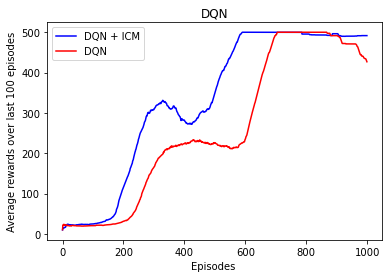

In [16]:
# We have episodic rewards with us 
#print(episodic_rewards)
# Plotting function 
plt.plot(episodic_rewards   , color='blue', label='DQN + ICM')
plt.plot(episodic_rewards_1 , color='red',  label='DQN')

plt.xlabel('Episodes ')
plt.ylabel(' Average rewards over last 100 episodes ')
plt.title('DQN')
plt.legend()

plt.show()